# Comparing PR using the normal strategy

In [ ]:
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.predictions import confidence_interval

def plot_kde_with_confidence_intervals(file_path, share_x_axis=True):
    # Load the JSON data
    with open(file_path, 'r') as file:
        data_dict = json.load(file)

    # Extract real_theta and remove it from the dictionary
    real_theta = data_dict['real_theta']
    data_dict.pop('real_theta')

    # Create subplots
    n_obs_list = list(data_dict.keys())
    fig, axes = plt.subplots(nrows=len(n_obs_list), ncols=1, figsize=(12, 4 * len(n_obs_list)), sharex=share_x_axis)

    # Iterate over the data
    for ax, n_obs in zip(axes, n_obs_list):
        resample_dict = data_dict[n_obs]
        for n_resample, theta_dist in resample_dict.items():
            # Create a KDE plot using seaborn
            kde = sns.kdeplot(theta_dist, ax=ax, label=f'n_resample: {n_resample}', fill=False)

            # Get the color of the current line
            line_color = kde.get_lines()[-1].get_color()

            # Calculate and plot the confidence interval
            lower_bound, _, upper_bound = confidence_interval(theta_dist, alpha=0.05)
            ax.axvline(lower_bound, color=line_color, linestyle=':', linewidth=1)
            ax.axvline(upper_bound, color=line_color, linestyle=':', linewidth=1)

        # Add a vertical line for the real value of theta
        ax.axvline(real_theta, color='r', linestyle='--', linewidth=1, label=f'Real Theta: {real_theta}')

        # Set labels and title for each subplot
        ax.set_title(f'n_obs: {n_obs}')
        ax.set_ylabel('Density')
        ax.legend(title='n_resample', bbox_to_anchor=(1.05, 1), loc='upper left')

    
    # Set common labels
    plt.xlabel('Theta')
    plt.suptitle('KDE of Theta Distributions with Real Theta and 5% CI', y=1.02)
    plt.tight_layout()

    plt.plot()

# TMixture data

## Mean

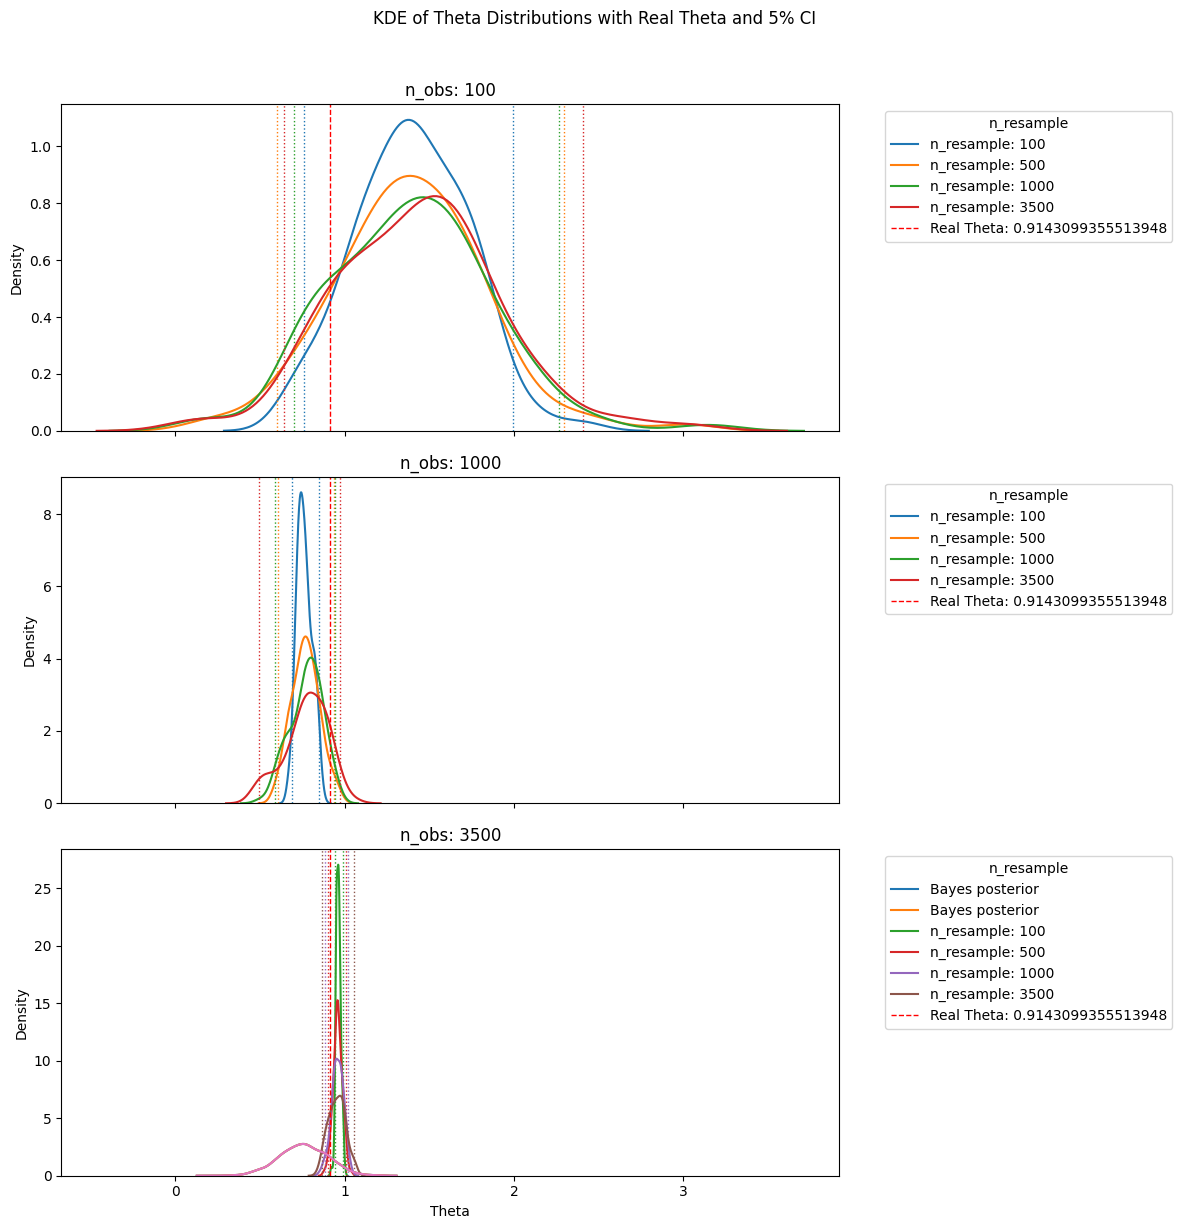

In [44]:
file_path = "predictions/mean/april08_april08_tmixture_data_pr.json"
plot_kde_with_confidence_intervals(file_path, share_x_axis=True)  # Set to False for independent x-axes

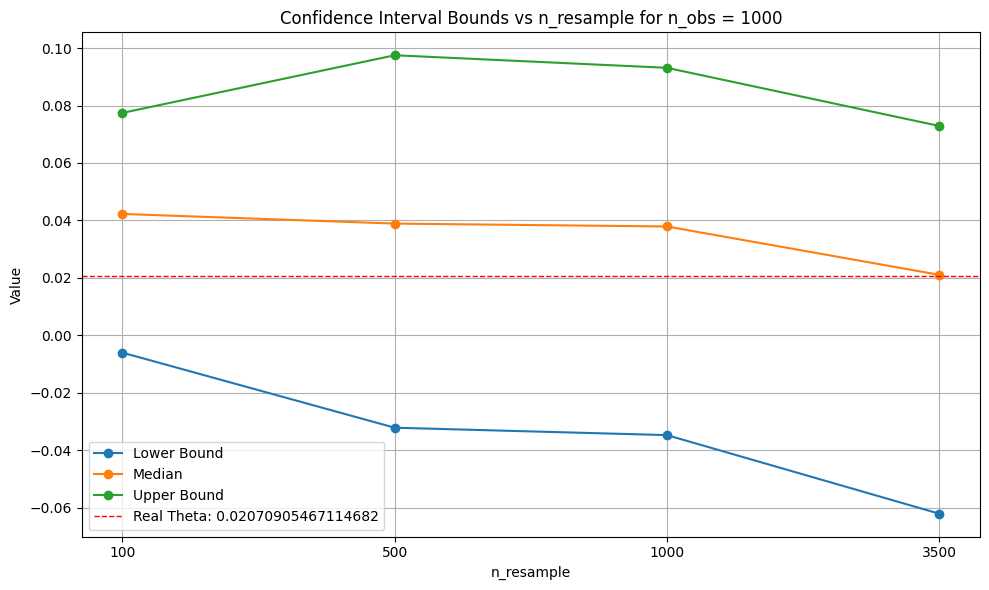

In [25]:
import json
import numpy as np
import matplotlib.pyplot as plt
from src.predictions import confidence_interval

def plot_bounds_vs_n_resample(data_dict, n_obs, real_theta, alpha=0.05):
    """
    Plot the upper, median, and lower bounds of the confidence interval as a function of n_resample,
    including the real value of theta.

    Parameters:
    - data_dict: Dictionary containing the data.
    - n_obs: The specific n_obs value to plot.
    - real_theta: The real value of theta to be plotted.
    - alpha: Significance level for the confidence interval (default is 0.05).
    """
    # Extract the data for the specified n_obs
    resample_dict = data_dict[n_obs]

    # Prepare lists to store the results
    n_resample_values = []
    lower_bounds = []
    medians = []
    upper_bounds = []

    # Iterate over the n_resample values
    for n_resample, theta_dist in resample_dict.items():
        # Calculate the confidence interval
        lower_bound, median, upper_bound = confidence_interval(theta_dist, alpha)

        # Store the results
        n_resample_values.append(n_resample)
        lower_bounds.append(lower_bound)
        medians.append(median)
        upper_bounds.append(upper_bound)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(n_resample_values, lower_bounds, label='Lower Bound', marker='o')
    plt.plot(n_resample_values, medians, label='Median', marker='o')
    plt.plot(n_resample_values, upper_bounds, label='Upper Bound', marker='o')

    # Add a horizontal line for the real value of theta
    plt.axhline(real_theta, color='r', linestyle='--', linewidth=1, label=f'Real Theta: {real_theta}')

    # Add labels and title
    plt.xlabel('n_resample')
    plt.ylabel('Value')
    plt.title(f'Confidence Interval Bounds vs n_resample for n_obs = {n_obs}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
file_path = "predictions/skewness/april08_april08_exchangeable_data_pr.json"
with open(file_path, 'r') as file:
    data_dict = json.load(file)

# Extract and remove real_theta from the dictionary
real_theta = data_dict.pop('real_theta', None)

# Plot for a specific n_obs
plot_bounds_vs_n_resample(data_dict, n_obs='1000', real_theta=real_theta)

## Comparing the Normal strategy and the regular Bayes prior with the TMixture data

In [ ]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Generate synthetic data
data = np.load('data/april08_tmixture_data.npy')[0:1000]

# Define the model
with pm.Model() as model:
    # Priors for mixture weights
    weights = pm.Dirichlet('weights', a=np.ones(3))
    
    # Fixed degrees of freedom
    nu = 3
    
    # Priors for the means
    mu = pm.Normal('mu', mu=0, sigma=10, shape=3)
    
    # Fixed sigma
    sigma = 1.0
    
    # Mixture model
    components = pm.StudentT.dist(nu=nu, mu=mu, sigma=sigma, shape=3)
    mixture = pm.Mixture('mixture', w=weights, comp_dists=components, observed=data)
    
    # Inference using NUTS
    trace = pm.sample(1000, tune=1000, return_inferencedata=True, target_accept=0.9)

# Extract posterior samples
posterior_samples = trace.posterior.stack(samples=("chain", "draw"))

import arviz as az
# Visualization
az.plot_trace(trace)
az.plot_posterior(trace)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [weights, mu]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [50]:
# Getting distribtion of overall mean
posterior_mean_dist = np.zeros(2000)
for i in range(3):
    posterior_mean_dist += posterior_samples['weights'][i, :] * posterior_samples['mu'][i, :]

Comparing the inference of the mean with PR and regular Bayesian inference using the fact that the mean is the weighted average of the means of each component.

[]

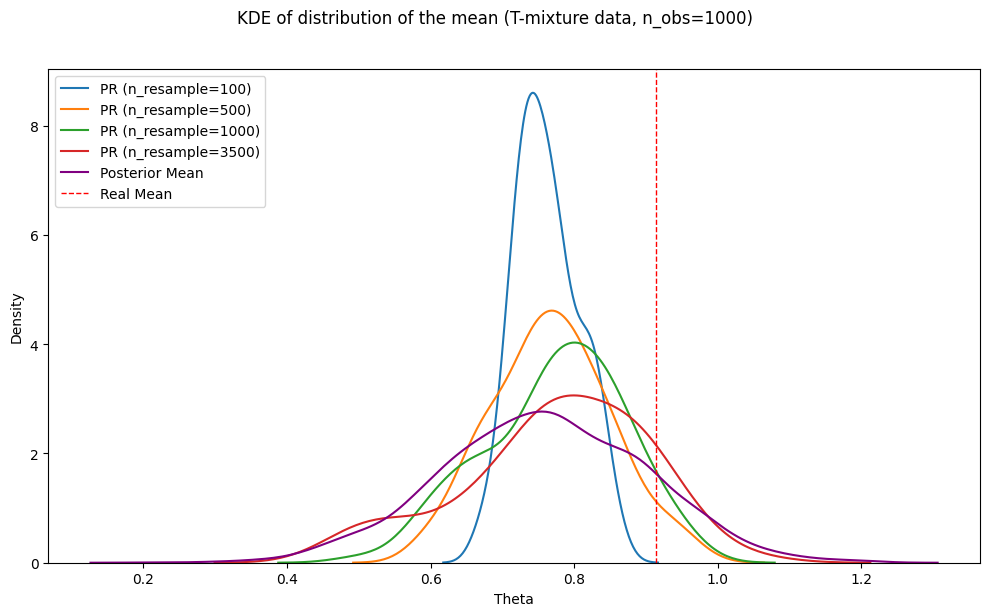

In [77]:
import json
file_path = "predictions/mean/april08_april08_tmixture_data_pr.json"
with open(file_path, 'r') as file:
    data_dict = json.load(file)

# Extract real_theta and remove it from the dictionary
real_theta = data_dict['real_theta']
data_dict.pop('real_theta')

# Iterate over the data
n_obs = '1000'
resample_dict = data_dict[n_obs]

plt.figure(figsize=(10, 6))
for n_resample, theta_dist in resample_dict.items():
    # Create a KDE plot using seaborn
    kde = sns.kdeplot(theta_dist, label=f'PR (n_resample={n_resample})', fill=False)

    # # Get the color of the current line
    # line_color = kde.get_lines()[-1].get_color()

    # # Calculate and plot the confidence interval
    # lower_bound, _, upper_bound = confidence_interval(theta_dist, alpha=0.05)
    # plt.axvline(lower_bound, color=line_color, linestyle=':', linewidth=1)
    # plt.axvline(upper_bound, color=line_color, linestyle=':', linewidth=1)

# Add BAyesian posterior
sns.kdeplot(posterior_mean_dist, label='Posterior Mean', fill=False, color='purple')

# Add a vertical line for the real value of theta
plt.axvline(real_theta, color='r', linestyle='--', linewidth=1, label=f'Real Mean')

plt.legend(loc='upper left')


# Set common labels
plt.xlabel('Theta')
plt.suptitle(f"KDE of distribution of the mean (T-mixture data, n_obs={n_obs})", y=1.02)
plt.tight_layout()

plt.plot()

Initializing NUTS using jitter+adapt_diag...
/home/charl/repos/bayesian-prediction/.venv/lib/python3.12/site-packages/pytensor/link/c/cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Sequential sampling (2 chains in 1 job)
NUTS: [weights, nu, mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 68 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'mu\n0'}>,
        <Axes: title={'center': 'mu\n1'}>,
        <Axes: title={'center': 'mu\n2'}>],
       [<Axes: title={'center': 'weights\n0'}>,
        <Axes: title={'center': 'weights\n1'}>,
        <Axes: title={'center': 'weights\n2'}>],
       [<Axes: title={'center': 'nu\n0'}>,
        <Axes: title={'center': 'nu\n1'}>,
        <Axes: title={'center': 'nu\n2'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>]], dtype=object)

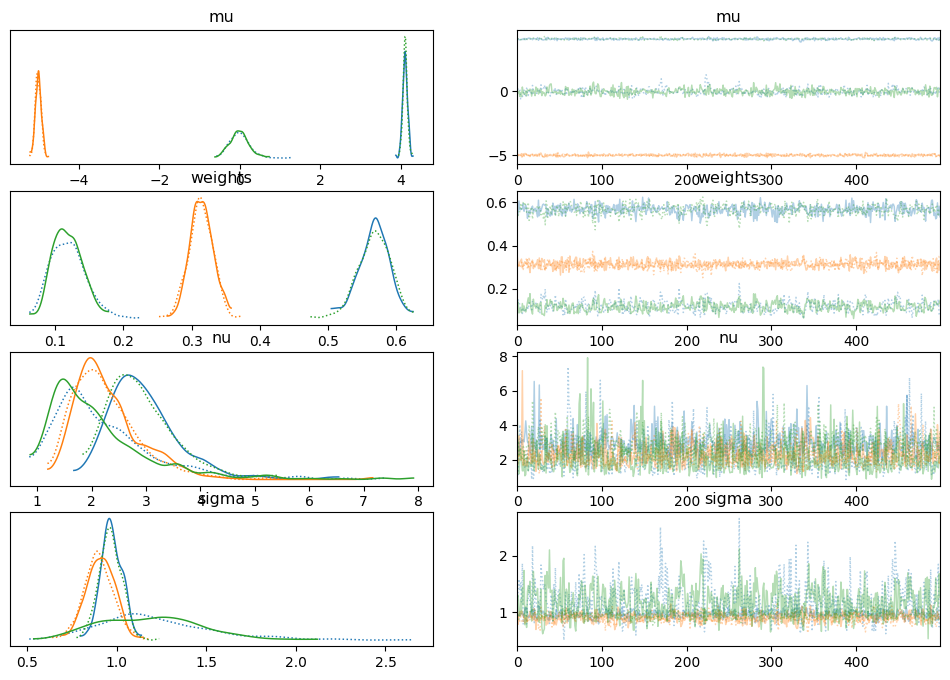

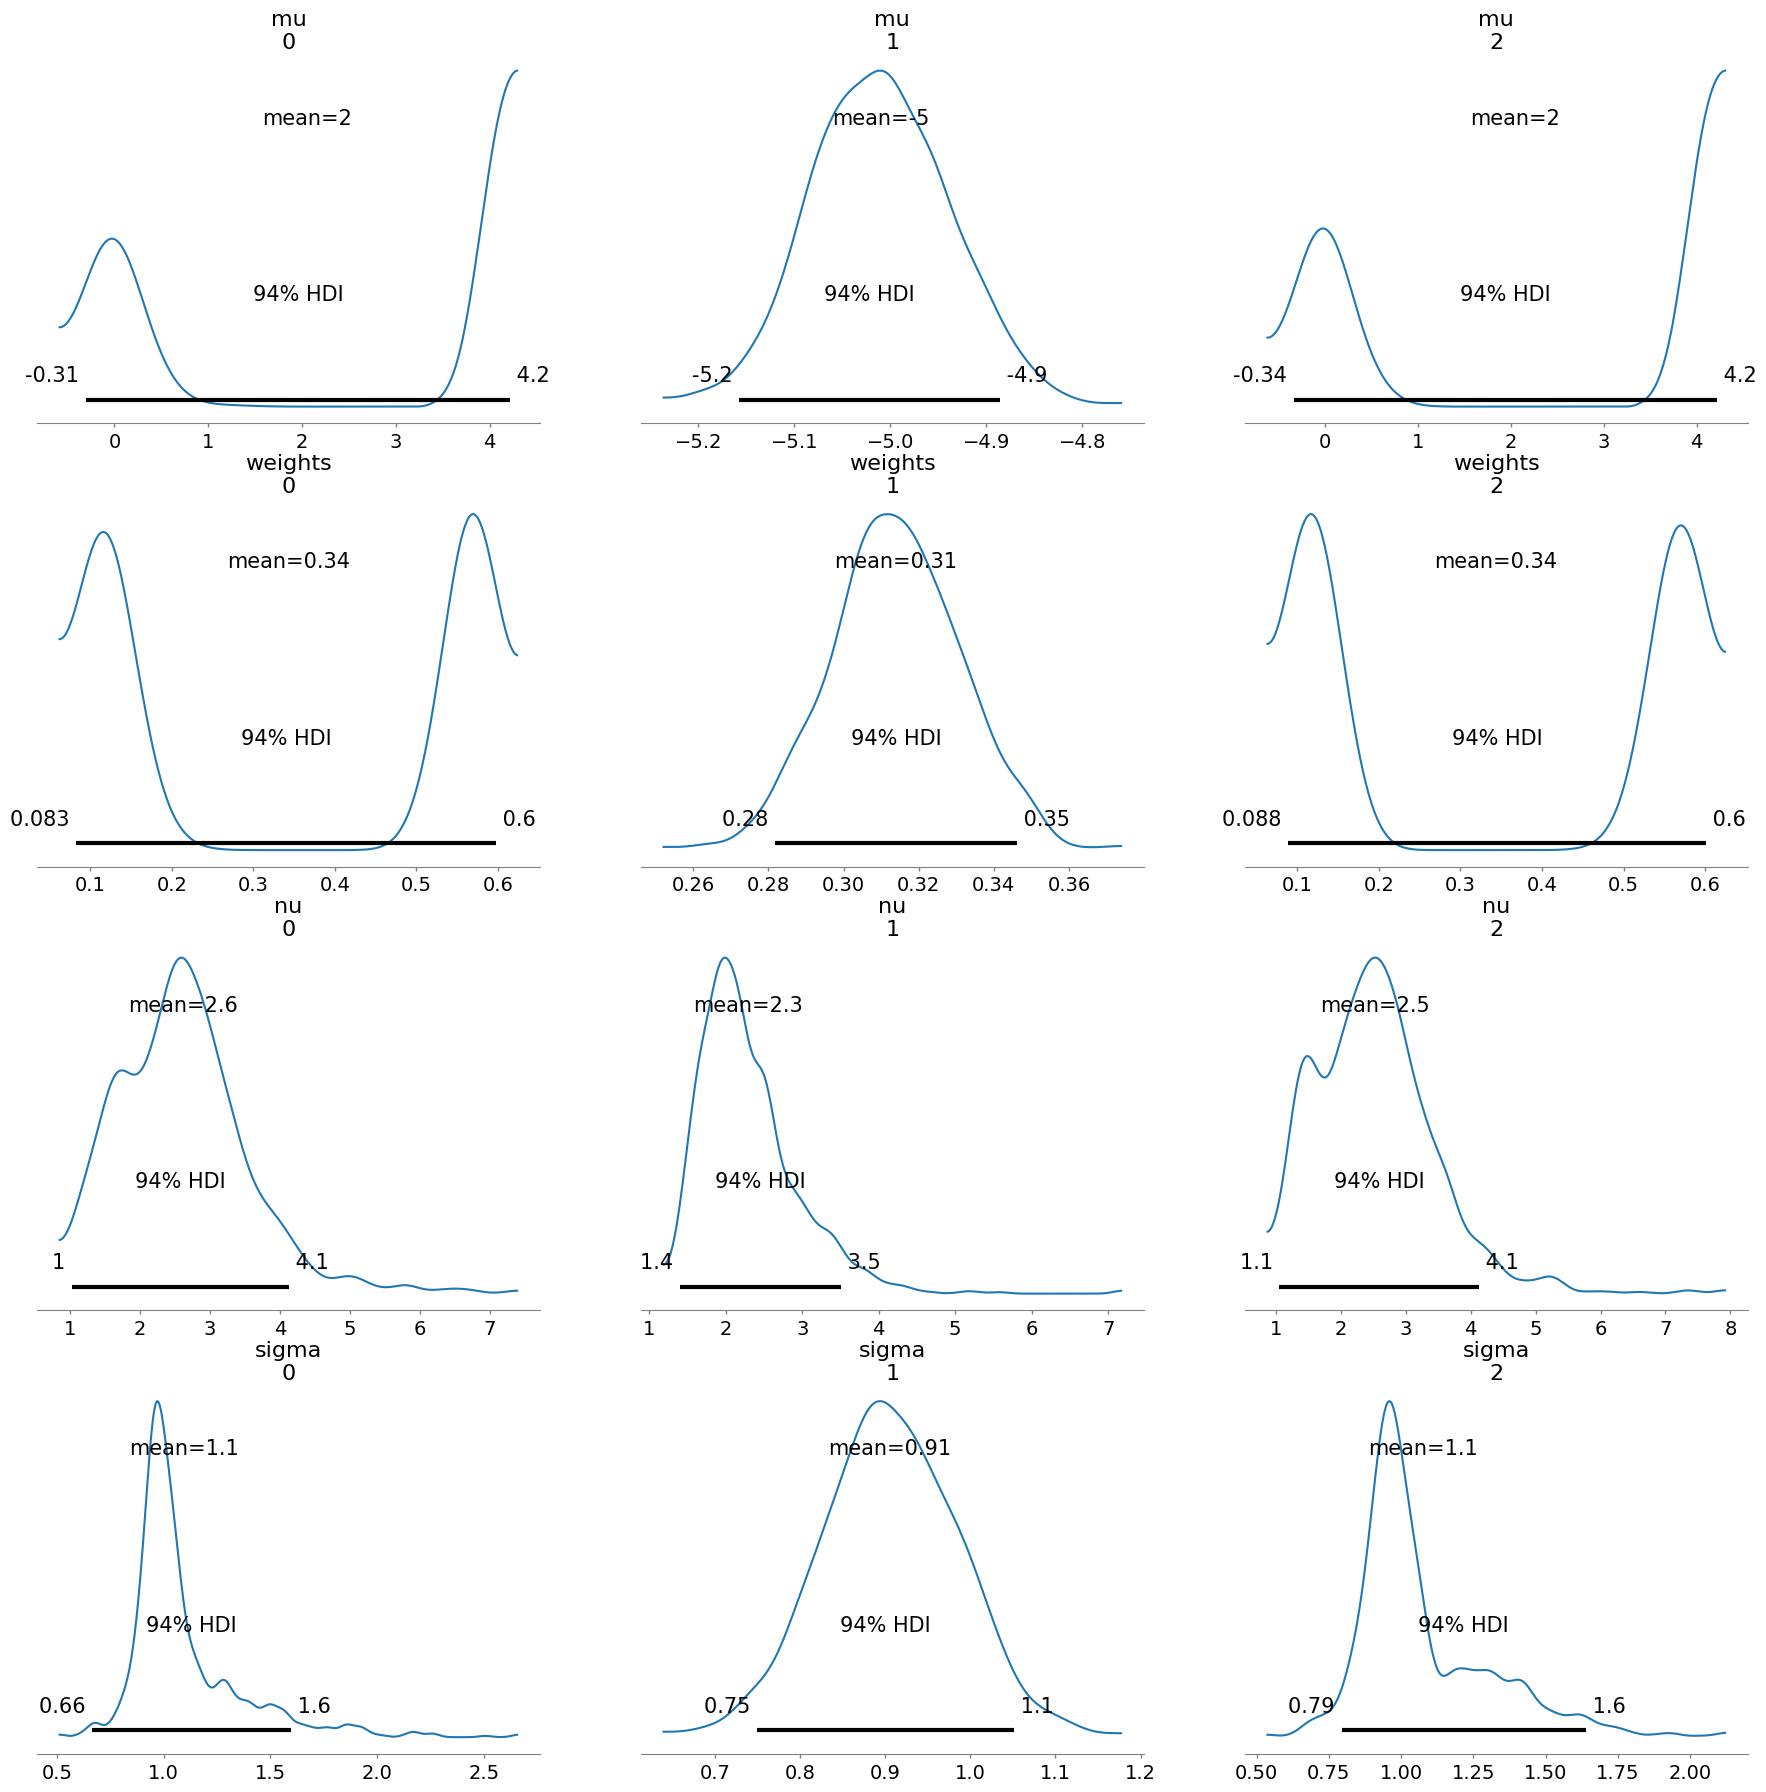

In [4]:
import pymc as pm
import numpy as np
import arviz as az

# Number of components
n_components = 3

# Generate some synthetic data or use your own
data = np.load("data/april08_tmixture_data.npy")[0:1000]
with pm.Model() as model:
    # Priors for mixture weights
    weights = pm.Dirichlet('weights', a=np.ones(n_components))
    
    # Priors for the Student-t parameters
    nu = pm.Exponential('nu', 1.0, shape=n_components)
    mu = pm.Normal('mu', mu=0, sigma=10, shape=n_components)
    sigma = pm.HalfNormal('sigma', sigma=1, shape=n_components)
    
    # Mixture model
    components = pm.StudentT.dist(nu=nu, mu=mu, sigma=sigma, shape=n_components)
    mixture = pm.Mixture('mixture', w=weights, comp_dists=components, observed=data)
    
    # Inference
    trace = pm.sample(500, return_inferencedata=True)

# Posterior analysis
posterior_samples = trace.posterior.stack(samples=("chain", "draw"))
means = (posterior_samples['weights'] * posterior_samples['mu']).sum(axis=1)
stds = (posterior_samples['weights'] * posterior_samples['sigma']).sum(axis=1)

# Calculate skewness and kurtosis
# Note: You might need to implement custom functions to calculate these from the samples

# Visualization
az.plot_trace(trace)
az.plot_posterior(trace)

In [29]:
from src.utils import ecdf_inv
import numpy as np
from tqdm import tqdm

n_obs = 1000
n_res = 4000  # number of resamples
B = 500  # number of bootstrap samples
x_obs = np.random.normal(0, 1, n_obs)

def theta_func(x):
    return np.mean(x)

# Bayesian Bootstrap
bb_theta_rubin = []
bb_theta_ecdfinv = []
pr_theta = []
for i in tqdm(range(B)):
    # BB
    # Rubin 1981 BB for new sampling
    u_sorted = np.sort(np.random.uniform(0, 1, n_obs-1))
    u_sorted = np.concatenate(([0], u_sorted, [1]))
    g = np.diff(u_sorted)

    bb_theta_rubin.append(np.sum(g * x_obs))  # Note as they are diff of sorted, sum(g) = 1
    # ECDF inversion BB for new sampling
    u = np.random.uniform(0, 1, n_obs)
    new_samples = ecdf_inv(x_obs, u)
    bb_theta_ecdfinv.append(theta_func(new_samples))
    
    # PR
    pr_samples = np.concatenate([x_obs, np.zeros(n_res)])
    for i in range(n_res):
        u_pr = np.random.uniform(0, 1)
        pr_samples[n_obs + i] = ecdf_inv(x_obs, u_pr)
        pr_theta.append(theta_func(pr_samples[:n_obs + i + 1]))

    


100%|██████████| 500/500 [04:02<00:00,  2.06it/s]


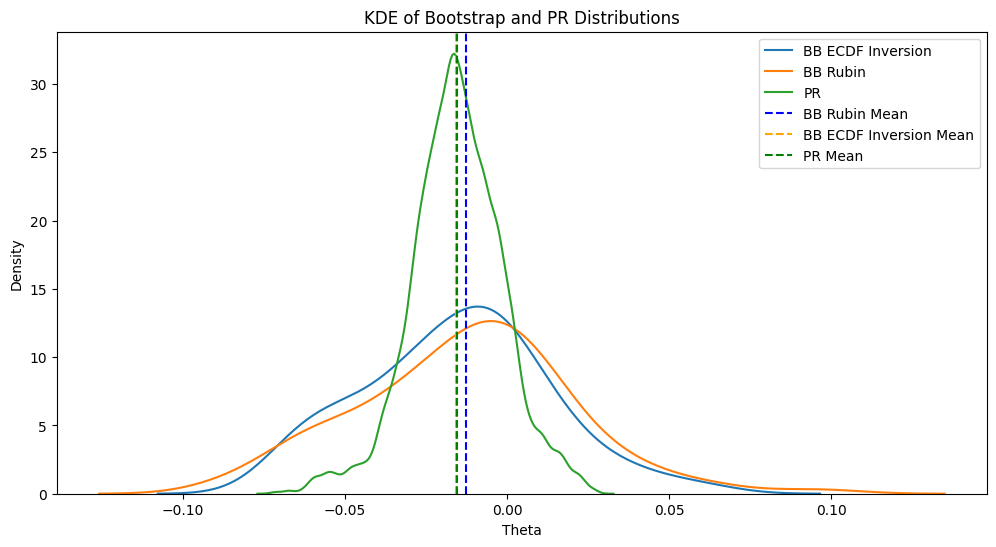

In [28]:
# Plotting KDEs
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
# sns.kdeplot(bb_theta_rubin, label='BB Rubin', fill=False)
sns.kdeplot(bb_theta_ecdfinv, label='BB ECDF Inversion', fill=False)
sns.kdeplot(bb_theta_rubin, label='BB Rubin', fill=False)
sns.kdeplot(pr_theta, label='PR', fill=False)
plt.axvline(np.mean(bb_theta_rubin), color='blue', linestyle='--', label='BB Rubin Mean')
plt.axvline(np.mean(bb_theta_ecdfinv), color='orange', linestyle='--', label='BB ECDF Inversion Mean')
plt.axvline(np.mean(pr_theta), color='green', linestyle='--', label='PR Mean')
plt.xlabel('Theta')
plt.ylabel('Density')
plt.title('KDE of Bootstrap and PR Distributions')
plt.legend()
plt.show()

In [74]:
print(np.sum(g))

0.9999999999999999
